# Training UNet for drop segmentation

In [45]:
import torch

In [57]:
config = {
    "lr": 0.001,
    "batch_size": 16,
    "epochs": 20,
    "threshold": 0.3,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint": "checkpoint.pt"
}
print(f"Training using {config['device']}")

Training using cuda


In [47]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 39 batches
Val: 67 images, 5 batches


In [48]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
model = UNet(3).to(config['device'])
init_weights(model, torch.nn.init.normal_, mean=0., std=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

model.train()

UNet(
  (ups): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReL

In [49]:
def check_accuracy_and_save(model, optimizer, epoch, train_loss):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
    }, config["checkpoint"])

    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            preds = torch.sigmoid(model(x))
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
    print(f"Dice Score = {dice_score/len(val_dataset)}")
    model.train()

In [55]:
from tqdm.notebook import tqdm
from sys import stdout
def train():
    for epoch in range(config['epochs']):
        print("Epoch", epoch)
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Average loss:", mean_loss)
        check_accuracy_and_save(model, optimizer, epoch, mean_loss)

In [58]:
train()

Epoch 0


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.42935283138201785
Dice Score = 0.04371558874845505
Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.42246414453555375
Dice Score = 0.04087787866592407
Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.4185548776235336
Dice Score = 0.041446518152952194
Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.41954865975257677
Dice Score = 0.04267597571015358
Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.4210860278361883
Dice Score = 0.04172668606042862
Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.4094646787032103
Dice Score = 0.04266202449798584
Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.3992394980711815
Dice Score = 0.04413103312253952
Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.3999858926504086
Dice Score = 0.04528474062681198
Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.40839283359356415
Dice Score = 0.042078495025634766
Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.40617577234903973
Dice Score = 0.03969144821166992
Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.3892561403604654
Dice Score = 0.04393399506807327
Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.4005620074577821
Dice Score = 0.04138883203268051
Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.3868249501937475
Dice Score = 0.04383121058344841
Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.38946941571357924
Dice Score = 0.043120358139276505
Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.38462529885463226
Dice Score = 0.040753625333309174
Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Average loss: 0.3960049312848311
Dice Score = 0.0452384389936924
Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Estimation

In [59]:
def get_full_prediction(model, x, y):
    image_np = x.detach().numpy()[0][0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    return image_np, gt_np, pred_np

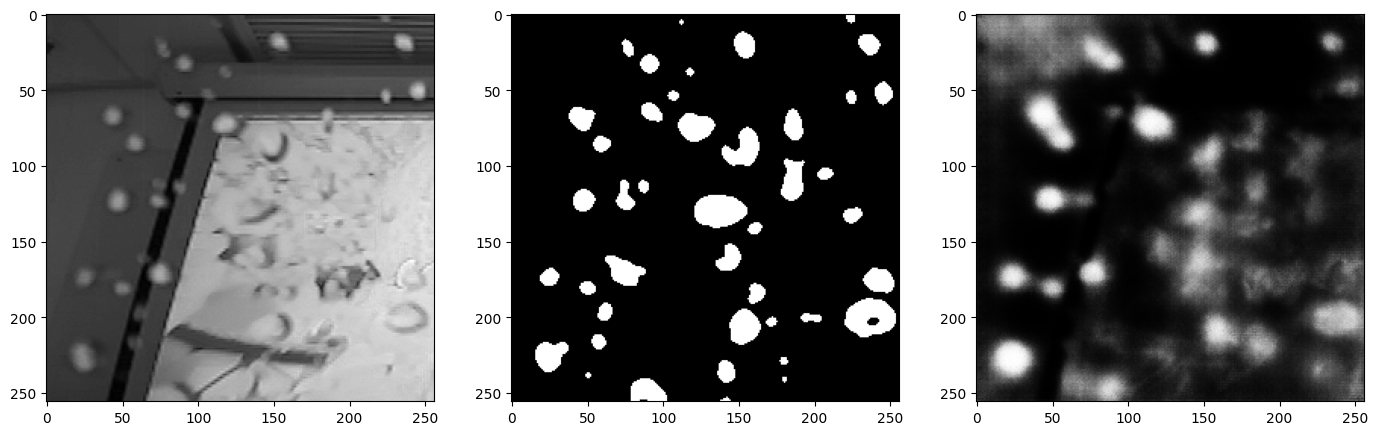

In [62]:
idx = 3
x, y = val_dataset.dataset[idx]
x = torch.stack([x])
y = torch.stack([y])
x, y, pred = get_full_prediction(model, x, y)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(17, 10))
axs[0].imshow(x, cmap='gray')
axs[1].imshow(y, cmap='gray')
axs[2].imshow(pred, cmap='gray')